In [62]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
 
import seaborn as sns
 
import numpy as np
 
import matplotlib.pyplot as plt
 
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
 
from scipy.sparse import csr_matrix
 
from surprise import Reader, Dataset
 
from surprise.model_selection import train_test_split
 
from surprise import SVDpp, accuracy
 
from surprise.model_selection import cross_validate
 
from collections import defaultdict
 
from surprise import SVD, SVDpp, NMF
 
from surprise import SlopeOne, CoClustering

import matplotlib

In [8]:
df_all = pd.read_csv("ratings.csv")

In [9]:
df_all.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [10]:
df_all.shape

(100004, 4)

In [11]:
df_all.nunique()

userId         671
movieId       9066
rating          10
timestamp    78141
dtype: int64

In [12]:
Sparsity = 1-100004/(671*9066)
Sparsity

0.9835608583913366

In [13]:
# Check movie's number of ratings
df_all.groupby("movieId")['rating'].count().sort_values(ascending=False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

In [14]:
df_all.groupby("movieId")['rating'].count().sort_values(ascending=True).head()

movieId
163949    1
26485     1
26480     1
26471     1
26467     1
Name: rating, dtype: int64

In [15]:
# Check user's number of rating

In [16]:
df_all.groupby("userId")['rating'].count().sort_values(ascending=False).head()

userId
547    2391
564    1868
624    1735
15     1700
73     1610
Name: rating, dtype: int64

In [17]:
df_all.groupby("userId")['rating'].count().sort_values(ascending=True).head()

userId
1      20
498    20
448    20
445    20
444    20
Name: rating, dtype: int64

In [18]:
#df = pd.read_csv("/Users/shulundong/Desktop/ML Final Project/final_movie_dataset_wstoryline.csv")

In [19]:
#df.head()

In [20]:
#df.groupby("movieId")['rating'].count().sort_values(ascending=False).head()

In [21]:
#df_agg = df[['userId', 'movieId']].groupby(['movieId']).agg(['count']).sort_values(('userId','count'), ascending=False)

In [22]:
#df_agg

In [23]:
#df_collab = df[['userId', 'movieId', 'rating', 'timestamp']]

We will exclude rarely rated movies to make our recommendation engine more relevant；
To make recommender more relevant, we will also exclude users that did not rate at least 200 movies.

#### Create a utility matrix

In [24]:
%%time
utilitymtx = df_all.pivot_table(values='rating', index='userId', columns='movieId', fill_value=0)

Wall time: 941 ms


In [25]:
utilitymtx

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


## 1. SVD
Applying data dimension reduction methods, specifically SVD, is one of the popular solutions for the sparsity problems. SVD is a matrix factorization algorithm that can extract characteristics of the dataset’s features by splitting the original user-item ratings matrix into three smaller matrix multiplications. Given a 𝑚𝑥 matrix A (N is the number of items, M is the number of users) with rank(𝐴) = r

https://www.alpha-quantum.com/blog/collaborative-filtering-recommender-systems/collaborative-filtering-recommender-system-with-python-from-scratch-using-svd-item-based-model-based-approaches/


In [26]:
SVD = TruncatedSVD(n_components=12, random_state=17)
resultant_matrix = SVD.fit_transform(utilitymtx)
resultant_matrix.shape

(671, 12)

In [27]:
resultant_matrix

array([[ 1.07914743e+00,  9.52010569e-01,  3.06132420e-01, ...,
         1.68394895e-01,  4.25725636e-01,  5.77706832e-01],
       [ 9.47543720e+00,  1.58795163e+00, -1.35576338e+01, ...,
        -1.31492488e+00, -3.68917831e-01,  9.85271177e-01],
       [ 7.81091998e+00, -3.23297075e+00, -2.29537308e+00, ...,
        -3.99929558e-01, -2.01415533e+00,  9.08696077e-01],
       ...,
       [ 3.62297938e+00,  3.85889961e-01,  7.96649539e-03, ...,
         2.95660625e-01, -1.40783247e+00, -1.10080853e+00],
       [ 6.58375511e+00, -2.74549235e-01, -3.07778061e+00, ...,
        -6.76961708e-01, -1.48873663e+00, -1.98765362e+00],
       [ 2.08411106e+01, -4.67025108e+00, -6.63159826e-01, ...,
         7.47804267e-01, -6.22442740e+00, -3.74035138e+00]])

If there is little data available model-based CF model will predict poorly since it will be more difficult to learn the latent features.

### SVD Matrix Factorization User Movie interactions

However, only captures the relationship between the user and the item . In the real world, the observed rating may be affected by the preference of the user or the characteristics of the item.

In [28]:
#find the max and min rating score
max_rate = max(df_all['rating'].values)
min_rate = min(df_all['rating'].values)

In [29]:
max_rate, min_rate

(5.0, 0.5)

In [30]:
reader = Reader(rating_scale=(min_rate,max_rate))
 
data = Dataset.load_from_df(df_all[['userId', 'movieId', 'rating']], reader)

In [31]:
df_all[['userId', 'movieId', 'rating']]

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


### SVD Matrix Factorization with implicit feedback from user ( user rated movies )

SVD++ approach improves on Matrix-factorization approach by including not only explicit ratings, but also implicit ones (e.g. purchases, likes, etc.). Another difference is that SVD++ adds user and item bias terms to the term for MF

In [32]:
trainset = data.build_full_trainset()

In [33]:
%%time
algo = SVDpp()
 
algo.fit(trainset);

Wall time: 5min 49s


In [34]:
user_id = trainset.to_raw_uid(1)
 
movie_id = trainset.to_raw_iid(1029)
 
prediction = algo.predict(uid=user_id, iid=movie_id)

In [35]:
prediction

Prediction(uid=2, iid=3390, r_ui=None, est=3.335990758572163, details={'was_impossible': False})

In [36]:
user_id = trainset.to_raw_uid(10)
 
movie_id = trainset.to_raw_iid(1029)
 
prediction2 = algo.predict(uid=user_id, iid=movie_id)

In [37]:
prediction2

Prediction(uid=11, iid=3390, r_ui=None, est=3.634911159435288, details={'was_impossible': False})

In [38]:
# Make recommendation for all users

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [39]:
testset = trainset.build_anti_testset()

In [40]:
predictionls = algo.test(testset)

In [41]:
top_n = get_top_n(predictionls, n=10)

In [42]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 [318, 2542, 116797, 7502, 1217, 5971, 2318, 527, 8132, 2324]
2 [969, 2467, 318, 5952, 1172, 3462, 2571, 4993, 1203, 905]
3 [2542, 2467, 4011, 116797, 1136, 3462, 7502, 745, 5971, 969]
4 [1172, 50, 527, 593, 318, 2858, 2959, 1221, 2019, 2324]
5 [2542, 3462, 318, 116797, 73290, 969, 905, 8132, 1217, 741]
6 [50, 4993, 296, 858, 527, 7502, 1203, 899, 1221, 905]
7 [858, 296, 7502, 1221, 593, 926, 50, 608, 2318, 2858]
8 [7502, 8132, 1221, 608, 79132, 1945, 913, 1212, 58559, 1939]
9 [858, 8132, 969, 905, 7502, 1203, 4993, 904, 2019, 3462]
10 [1172, 8132, 2318, 969, 608, 1212, 1203, 7502, 858, 1945]
11 [2542, 2318, 318, 4011, 8132, 1237, 7502, 116797, 926, 2692]
12 [73290, 527, 2542, 905, 2804, 58559, 1196, 3088, 1172, 922]
13 [858, 2542, 2959, 1221, 1203, 8132, 3462, 969, 745, 3088]
14 [2542, 318, 3462, 1217, 116797, 8132, 1172, 969, 858, 7502]
15 [735, 596, 1563, 501, 3359, 1022, 116, 5114, 3310, 326]
16 [2542, 8132, 7502, 2329, 1945, 3462, 1939, 2318, 899, 1212]
17 [1203, 26587, 926, 2303

The drawback of memory-based CF is that it doesn’t scale to real-world scenarios and doesn’t address the well-known cold-start problem, that is when a new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don’t have any ratings enter the system.


### Neural Network Collaborative Filtering

https://medium.com/deep-recommender-system/a-deep-recommender-system-e2b765d27350

#### User Embedding
User Embeddings
Before we dive into the architecture of the model, let’s familiarize ourselves with the concept of embeddings. An embedding is a low-dimensional space that captures the relationship of vectors from a higher dimensional space. 

# 2. Testing TDS (Towards Data Science) Deep Learning Based RCF NCF w/ Pytorch

In [81]:
#Reading in the ratings CSV data
ratings = pd.read_csv("ratings.csv", parse_dates=['timestamp'])


#Randomly choosing 30% of the UserID Data
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

In [82]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [83]:
#Random split in this case would not make sense, potentially using user recent reviews from training and earlier reviews for testing, lookahead bias
#Splitting ratings dataset using leave-one-out methodology
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

### Converting DF to Implicit Feedback Dataset

"Instead of trying to predict movie ratings when using explicit feedback, we are trying to predict whether the user will interact (i.e. click/buy/watch) with each movie, with the aim of presenting to users the movies with the highest interaction likelihood." The problem is by binarizing the dataset, all of the data will now only include the positive class. It is important to also include the negative samples to train the model. Those movies that are considered a negative rating would be assumed that these users are not interested in them. (Huge Assumption, but ususally works out pretty well)

In [84]:
train_ratings.loc[:, 'rating'] = 1

In [85]:
## Creating 4 negative samples ffor each row of the data
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in user_item_set:
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

In [86]:
import torch
from torch.utils.data import Dataset

class MovieLensTrainDataset(Dataset):
    """MovieLens PyTorch Dataset for Training
    
    Args:
        ratings (pd.DataFrame): Dataframe containing the movie ratings
        all_movieIds (list): List containing all movieIds
    
    """

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

### Starting NCF (Neural Collaborative Filtering)

Concept of Embedding- An embedding is a low-dimensional space that captures the relationship of vectors from a higher dimensional space.

For Example:

Imagine that we want to represent our users according to their preference for two genres of movies — action and romance movies. Let the first dimension be how much the user likes action movies, and the second dimension be how much the user likes romance movies.

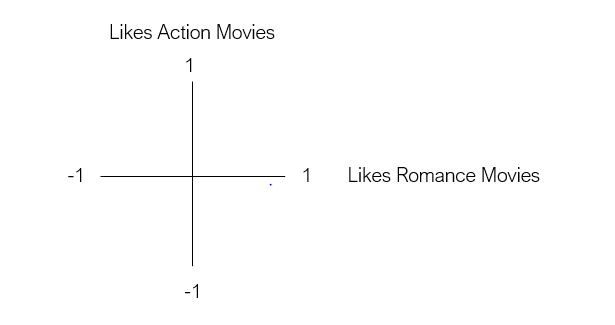

Now, assume that Bob is our first user. Bob likes action movies but isn’t a fan of romance movies. To represent Bob as a two dimensional vector, we place him in the graph according to his preference.

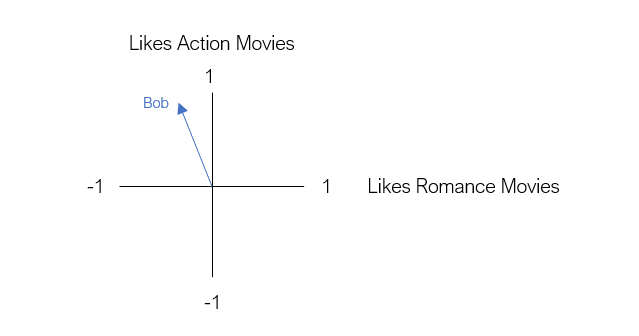

Our next user is Joe. Joe is a huge fan of both action and romance movies. We represent Joe using a two dimensional vector just like Bob.

This two dimensional space is known as an embedding. Essentially, the embedding reduces our users such that they can be represented in a meaningful manner in a lower dimensional space. In this embedding, users with similar movie preferences are placed near to each other, and vice versa.

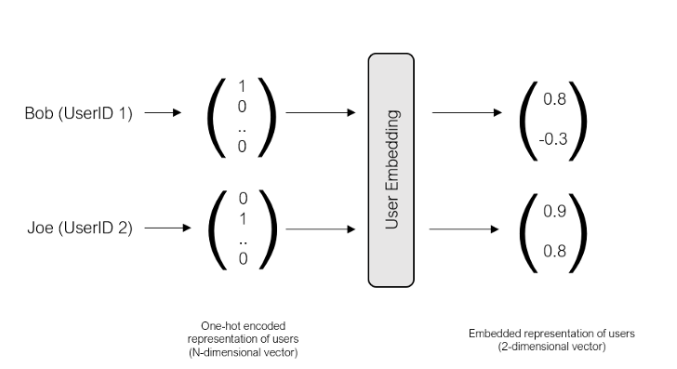

Of course, we are not restricted to using just 2 dimensions to represent our users. We can use an arbitrary number of dimensions to represent our users. A larger number of dimensions would allow us to capture the traits of each user more accurately, at the cost of model complexity. In our code, we’ll use 8 dimensions (which we will see later)

In [116]:
import torch.nn as nn
# One advantage of PyTorch Lightning over vanilla PyTorch is that you don’t need to write your own boiler plate training code. 
# Notice how the Trainer class allows us to train our model with just a few lines of code.
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class NCF(pl.LightningModule):
    """ Neural Collaborative Filtering (NCF)
    
        Args:
            num_users (int): Number of unique users
            num_items (int): Number of unique items
            ratings (pd.DataFrame): Dataframe containing the movie ratings for training
            all_movieIds (list): List containing all movieIds (train + test)
    """
    
    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=16)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=16)
        self.fc1 = nn.Linear(in_features=32, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds
        
    def forward(self, user_input, item_input):
        
        # Pass through embedding layers
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)

        # Concat the two embedding layers
        vector = torch.cat([user_embedded, item_embedded], dim=-1)

        # Pass through dense layer
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))
        vector = nn.ReLU()(self.fc3(vector))
        vector = nn.ReLU()(self.fc4(vector))

        # Output layer
        pred = nn.Sigmoid()(self.output(vector))

        return pred
    
    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = 0.01)

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=0)

In [119]:
num_users = ratings['userId'].max()+1
num_items = ratings['movieId'].max()+1
all_movieIds = ratings['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=50, reload_dataloaders_every_n_epochs = 1,
                     progress_bar_refresh_rate=50, logger=False, checkpoint_callback=False)

trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 10.8 K
1 | item_embedding | Embedding | 2.6 M 
2 | fc1            | Linear    | 2.1 K 
3 | fc2            | Linear    | 8.3 K 
4 | fc3            | Linear    | 8.3 K 
5 | fc4            | Linear    | 2.1 K 
6 | output         | Linear    | 33    
---------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.619    Total estimated model params size (MB)


Epoch 49: 100%|██████████| 971/971 [00:05<00:00, 192.82it/s, loss=0.187]


### Evaluating Recommender Systems

In [121]:
# User-item pairs for testing
test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

# Dict of all items that are interacted with by each user
user_interacted_items = ratings.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in test_user_item_set:
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]
    
    predicted_labels = np.squeeze(model(torch.tensor([u]*100), 
                                        torch.tensor(test_items)).detach().numpy())
    
    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)
        
print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

The Hit Ratio @ 10 is 0.61


# 3. Content Based Movie Recommendation System

In [395]:
df_rating = pd.read_csv("ratings.csv")
df_credits = pd.read_csv("credits.csv")
df_metadata = pd.read_csv("movies_metadata.csv")
df_link = pd.read_csv('links.csv')

C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df_rating.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
df_credits.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [15]:
df_metadata.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [10]:
df_link.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


###  Cleaning & Merging Data

In [219]:
df_link_clean = df_link[df_link['tmdbId'].notnull()]['tmdbId'].astype('int')

In [23]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [24]:
df_metadata['id'] = df_metadata['id'].apply(convert_int)
df_metadata[df_metadata['id'].isnull()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",NaN,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",NaN,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",NaN,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_metadata = df_metadata.drop([19730, 29503, 35587])

In [26]:
df_metadata['id'] = df_metadata['id'].astype('int')

In [38]:
final_metadata = df_metadata[df_metadata['id'].isin(df_link_clean)]
final_metadata.shape

(9099, 24)

### Storyline + Tagline + Title Content Based Recommendation

In [39]:
final_metadata.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0


In [44]:
final_metadata['imdb_id'] = final_metadata['imdb_id'].astype(str)
final_metadata['imdb_id']

C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        tt0114709
1        tt0113497
2        tt0113228
3        tt0114885
4        tt0113041
           ...    
40224    tt4262980
40503    tt2531318
44821    tt0235679
44826    tt0287635
45265    tt2121382
Name: imdb_id, Length: 9099, dtype: object

In [49]:
from imdb import Cinemagoer
from tqdm import tqdm, tqdm_notebook

ia = Cinemagoer()

storyline = []

for i in tqdm(final_metadata['imdb_id'].str[2:]):
    #print(i)
    movie = ia.get_movie(i)
    if 'plot outline' not in movie.data.keys():
        storyline.append("NA")
        continue
    sl = movie.data['plot outline']
    storyline.append(sl)

100%|██████████| 9099/9099 [3:36:06<00:00,  1.43s/it]  


In [50]:
storyline = pd.DataFrame(storyline)

In [89]:
final_df = pd.concat([final_metadata, storyline], axis=1)
final_df = final_df.rename(columns = {0:"storyline"})

In [90]:
final_df.to_csv('final_movie_dataset_wstoryline.csv')

In [22]:
final_df = pd.read_csv("final_movie_dataset_wstoryline.csv")

In [23]:
final_df.shape

(12329, 26)

In [24]:
final_df['tagline'] = final_df['tagline'].fillna('')
final_df['title'] = final_df['title'].fillna('')
final_df['description'] = final_df['title'] +  ' ' + final_df['storyline'] + ' ' + final_df['tagline']

In [25]:
final_df['description'].head(5)

0    Toy Story A little boy named Andy loves to be ...
1    Jumanji Jumanji, one of the most unique--and d...
2    Grumpier Old Men Things don't seem to change m...
3    Waiting to Exhale This story based on the best...
4    Father of the Bride Part II In this sequel to ...
Name: description, dtype: object

In [26]:
final_df = final_df.dropna(subset=['description'])

In [27]:
final_df['description'].isnull().sum()

0

In [40]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8694 entries, 0 to 9098
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             8694 non-null   int64  
 1   adult                  5632 non-null   object 
 2   belongs_to_collection  1029 non-null   object 
 3   budget                 5632 non-null   float64
 4   genres                 5632 non-null   object 
 5   homepage               443 non-null    object 
 6   id                     5632 non-null   float64
 7   imdb_id                5632 non-null   object 
 8   original_language      5632 non-null   object 
 9   original_title         5632 non-null   object 
 10  overview               5627 non-null   object 
 11  popularity             5632 non-null   float64
 12  poster_path            5629 non-null   object 
 13  production_companies   5632 non-null   object 
 14  production_countries   5632 non-null   object 
 15  rele

In [161]:
final_df.head()

,Unnamed: 0,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,storyline,description
0,0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862.0,tt0114709,en,Toy Story,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,,Toy Story,False,7.7,5415.0,A little boy named Andy loves to be in his roo...,Toy Story A little boy named Andy loves to be ...
1,1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844.0,tt0113497,en,Jumanji,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"Jumanji, one of the most unique--and dangerous...","Jumanji Jumanji, one of the most unique--and d..."
2,2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602.0,tt0113228,en,Grumpier Old Men,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,Things don't seem to change much in Wabasha Co...,Grumpier Old Men Things don't seem to change m...
3,3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357.0,tt0114885,en,Waiting to Exhale,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,This story based on the best selling novel by ...,Waiting to Exhale This story based on the best...
4,4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862.0,tt0113041,en,Father of the Bride Part II,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"In this sequel to ""Father of the Bride"", Georg...",Father of the Bride Part II In this sequel to ...


In [58]:
final_clean_df = final_df[['title', 'id', 'description', 'vote_count', 'vote_average', 'release_date']]

In [44]:
#!pip install pytorch-nlp
#!python -m spacy download en
#!python -m spacy download en_core_web_sm

In [45]:
import torch
from torchnlp.encoders.text import WhitespaceEncoder
from torchnlp.word_to_vector import GloVe

encoder = WhitespaceEncoder(final_clean_df['description'])

vocab = set(encoder.vocab)
pretrained_embedding = GloVe(name='6B', dim=100, is_include=lambda w: w in vocab)
embedding_weights = torch.Tensor(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

100%|██████████| 400000/400000 [00:02<00:00, 198194.17it/s]


In [46]:
embedding_weights

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.8134,  0.3270,  0.3426,  ...,  0.2271,  0.5197,  0.4945],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4604,  0.1265,  0.1635,  ...,  0.6304, -0.5531,  0.4174]])

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(final_clean_df['description'])

In [48]:
count_matrix

<8694x455664 sparse matrix of type '<class 'numpy.int64'>'
	with 925495 stored elements in Compressed Sparse Row format>

In [49]:
len(embedding_weights)

90761

In [50]:
len(embedding_weights[0])

100

In [51]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(final_clean_df['description'])

In [52]:
tfidf_matrix

<8694x455664 sparse matrix of type '<class 'numpy.float64'>'
	with 925495 stored elements in Compressed Sparse Row format>

In [59]:
# Define similarity function and 
from numpy import dot
from numpy.linalg import norm

def cosine_sim(list1, list2):
    result = dot(list1, list2)/(norm(list1)*norm(list2))
    return result

In [60]:
final_clean_df = final_clean_df.reset_index()
titles = final_clean_df['title']
indices = pd.Series(final_clean_df.index, index=final_clean_df['title'])

In [68]:
#TFIDF Similarity
cosine_sim_tfidf = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [69]:
#Count Vectorizer Similarity
cosine_sim_cv = cosine_similarity(count_matrix, count_matrix)

In [70]:
#GLOVE Similarity
cosine_sim_glove = cosine_similarity(embedding_weights, embedding_weights)

In [81]:
# Find movie with votes
vote_cnt = final_clean_df[final_clean_df['vote_count'].notnull()]['vote_count']

In [82]:
# Find movie with vote average
vote_avg = final_clean_df[final_clean_df['vote_average'].notnull()]['vote_average']

In [97]:
#Defining Weighted Rating through Vote Counts & Average
def weighted_rating(x):
    C = vote_avg.mean()
    m = vote_cnt.quantile(0.60)
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [116]:
#Content Based Similarity Recommendation TFIDF
def improved_recommendations_tfidf(title):
    idx = indices[title]
    #Find the cosine similarity score for this movie and 
    sim_scores = list(enumerate(cosine_sim_tfidf[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:30]
    
    #Find the similar movies index
    movie_indices = [i[0] for i in sim_scores]
    #Get movies' info including voting
    movies = final_clean_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date']]
    
    #Create a qualified list with weighted rating
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    #C = vote_avg.mean()
    #m = vote_cnt.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [117]:
improved_recommendations_tfidf('Jumanji')

C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,title,vote_count,vote_average,release_date,wr
6142,Man with a Movie Camera,114,8,1929-01-08,7.196390
7797,Collateral,1476,7,2004-08-04,6.955555
1382,Lost Highway,572,7,1997-01-15,6.896469
5679,Drumline,118,6,2002-12-13,6.166366
4283,The Dead Pool,227,6,1988-07-12,6.112235
4672,Spy Game,592,6,2001-11-18,6.053712
8,Sudden Death,174,5,1995-12-22,5.516307
6242,The League of Extraordinary Gentlemen,1181,5,2003-07-11,5.112955


In [126]:
#Content Based Similarity Recommendation CountVectorizer
def improved_recommendations_cv(title):
    idx = indices[title]
    #Find the cosine similarity score for this movie and 
    sim_scores = list(enumerate(cosine_sim_cv[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:30]
    
    #Find the similar movies index
    movie_indices = [i[0] for i in sim_scores]
    #Get movies' info including voting
    movies = final_clean_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'release_date']]
    
    #Create a qualified list with weighted rating
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    #C = vote_avg.mean()
    #m = vote_cnt.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [127]:
improved_recommendations_cv('Jumanji')

C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kenne\anaconda3\envs\torch_gpu\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,title,vote_count,vote_average,release_date,wr
6142,Man with a Movie Camera,114,8,1929-01-08,7.196390
7797,Collateral,1476,7,2004-08-04,6.955555
3807,Brewster's Millions,144,6,1985-05-22,6.149201
4283,The Dead Pool,227,6,1988-07-12,6.112235
4672,Spy Game,592,6,2001-11-18,6.053712
5426,The 51st State,173,5,2001-12-07,5.518145
8,Sudden Death,174,5,1995-12-22,5.516307
6242,The League of Extraordinary Gentlemen,1181,5,2003-07-11,5.112955


Assumptions & Interpretation:

1. In this specific recommendation system, we assume that the users have not watched all of the recommended movies listed
2. The WR is the weighted rating based on the vote count and vote average to give the recommended movie a specific weighted rating
3. This list is generated through by using a similarity function of title, tagline, and storyline of the movie. Then ranked the top 10 through the weighted rating.

# 4. Hybrid Recommendation Systems: Content + Collaborative

In [128]:
#find the max and min rating score
max_rate = max(df_rating['rating'].values)
min_rate = min(df_rating['rating'].values)

In [129]:
reader = Reader(rating_scale=(min_rate,max_rate))
 
data = Dataset.load_from_df(df_rating[['userId', 'movieId', 'rating']], reader)

In [130]:
trainset = data.build_full_trainset()

In [131]:
algo = SVDpp()
 
algo.fit(trainset);

In [260]:
final_clean_df.head()

,index,title,id,description,vote_count,vote_average,release_date
0,0,Toy Story,862.0,Toy Story A little boy named Andy loves to be ...,5415.0,7.7,1995-10-30
1,1,Jumanji,8844.0,"Jumanji Jumanji, one of the most unique--and d...",2413.0,6.9,1995-12-15
2,2,Grumpier Old Men,15602.0,Grumpier Old Men Things don't seem to change m...,92.0,6.5,1995-12-22
3,3,Waiting to Exhale,31357.0,Waiting to Exhale This story based on the best...,34.0,6.1,1995-12-22
4,4,Father of the Bride Part II,11862.0,Father of the Bride Part II In this sequel to ...,173.0,5.7,1995-02-10


In [396]:
def hybrid_recommendation_tfidf(title, user_id):
    #Get the recommendation movie list from the content based recommendation system
    idx = indices[title]
    #Find the cosine similarity score for this movie and 
    sim_scores = list(enumerate(cosine_sim_tfidf[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:30]
    
    #Find the similar movies index
    movie_indices = [i[0] for i in sim_scores]
    #Get movies' info including voting
    movies = final_clean_df.iloc[movie_indices][['id', 'title', 'vote_count', 'vote_average', 'release_date']]
    
    movies = movies.dropna()
    
    movies_link = movies.merge(df_link, how='inner', left_on='id', right_on='tmdbId')
    
    raw_user_id = trainset.to_raw_uid(user_id)    
    
    raw_movie_id = [trainset.to_raw_iid(int(x)) for x in movies_link['movieId']]
    
    movies['est_rate'] = [algo.predict(uid=raw_user_id, iid=x).est for x in raw_movie_id] 
    
    movies = movies.sort_values('est_rate', ascending=False).head(10)
    
    return movies

In [399]:
hybrid_output_tfidf = hybrid_recommendation_tfidf('Jumanji',  10)

In [400]:
hybrid_output_tfidf

,id,title,vote_count,vote_average,release_date,est_rate
3661,45905.0,The Opportunists,2.0,5.5,2000-05-17,4.382100
1382,638.0,Lost Highway,572.0,7.5,1997-01-15,4.244323
6659,48035.0,Ordet,66.0,7.8,1955-01-09,4.240881
7918,1435.0,Tarnation,22.0,7.5,2003-10-19,4.168065
8,9091.0,Sudden Death,174.0,5.5,1995-12-22,4.135744
2045,51942.0,I Married a Strange Person!,12.0,7.5,1998-08-28,4.069849
4180,26483.0,Beach Blanket Bingo,12.0,7.0,1965-04-14,4.021739
5679,13497.0,Drumline,118.0,6.2,2002-12-13,3.980511
4283,10651.0,The Dead Pool,227.0,6.3,1988-07-12,3.979477
6142,26317.0,Man with a Movie Camera,114.0,8.1,1929-01-08,3.974666


Assumptions & Interpretation:

1. In this specific recommendation system, we assume that the users have not watched all of the recommended movies listed
2. The EST_Rate is the estimated rating that the user will produce after watching the specific title. Different from the previous recommendation system, this recommendation system will now take in to the consideration of the user's given rating to rank the similar movies that are recommended.
3. From a business stand point, this recommendation system is able to recommend movies that are more likely to obtain a higher rating to the users first, thus either improving customer satisfaction of viewing the movie. Different from the previous model, the previous recommendation system, will only provide movies based on an overall weighted ranking score which does not 100% give us estimated feedback of what the user would think about the movie.

### Evaluation

#### Evaluation by statistical metrics

1. RMSE of predicted ratings --> Collaborative Filtering


2. Hit 10 Ratio 

- Process:
    - Find all items in this user’s history in the training data.
    - Intentionally remove one of these items ( Leave-One-Out cross-validation).
    - Use all other items to feed the recommender and ask for top 10 recommendations.
    - If the removed item appear in the top 10 recommendations, it is a hit. If not, it’s not a hit.

In [ ]:
LOOCV = LeaveOneOut(n_splits=1, random_state=1)

for trainSet, testSet in LOOCV.split(data):
    # Train model without left-out ratings
    algo.fit(trainSet)
    # Predicts ratings for left-out ratings only
    leftOutPredictions = algo.test(testSet)
    # Build predictions for all ratings not in the training set
    bigTestSet = trainSet.build_anti_testset()
    allPredictions = algo.test(bigTestSet)
    # Compute top 10 recs for each user
    topNPredicted = GetTopN(allPredictions, n=10)

In [ ]:
def HitRate(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0

 # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top 10 for this user?
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total
print("\nHit Rate: ", HitRate(topNPredicted, leftOutPredictions))

#### Evaluation by observation

By looking at the recommendation generated by our models, we can check if the recommended movies make sense or not.

#### Evaluation in real business context

Measure the user engagment

1. number of searches per user per week (The lesser it is the more our recommendation system is doing good that users are  directly coming here)
2. Like : Unlike Ratio in our Recommendation
3. number of movies added to watchlist per week from recommended ones
4. number of trailers watched from recommended movies per week
5. % of movies watched after watching trailer from recommended list
6. Ratio of movie watched through Recommendation : Ratio of movie watched through Search